# Recommendation Notebook 


## Notes

### 1/12
- Tweaked hyperparameters to get optimal performance (for now)
- Blank descriptions are now replaced with club name respectively
- Clubs that aren't confirmed are not included in dataset

### 1/10
- Create 3rd temporary recommendation system based off of favorites and interest lists. Basically just added case where favorites_list does not exist, so then tags are taken into consideration instead. This version still does not take tags into account when a favorites list does exist, however. We can improve this part if we want in future versions.

### 1/8
- Added .env variable support for use with version control
- Added frequency distribution graph for words from descriptions

### 1/6
- Created 2nd temporary recommendation system based off of favorites, would like to include tags incorporated, even though we use the recommendation function that takes into consideration tags already
- Figure out how to recommend even with no favorites, just tags

### 12/31
- Added various graphs for visualizing performance of model
- Fixed environment by list dependencies without specific versions
- Re-added directly importing data from MongoDB

### 12/30
- Will most likely want to give slack for k when recommending, since we don't want to have the exact same results each time
- (Possibly pick from distributions?)
- favorite_recommendation does not work as well as hoped, need to reevaluate how well it works + other strategies

### 12/28
- Switched from euclidean distance to cosine similarity
- Fixed runtime for vectorizing the table

### 12/23
- Annotation, a lot
- Recommend function takes into consideration tags
- Notebook formatted

### 12/10
- Started
- Issues importing from Tejas's environment, unable to connect to DB so exported directly from MongoDB
- Used nlp/gensim to vectorize description, use K-nn approach to recommend

# Imports

In [56]:
# import packages
# Native imports
import os
import json
import random

# MongoDB Python driver import
import pymongo

# 3rd-party data science imports
import pandas as pd
import seaborn as sns
# pd.set_option('display.max_rows', None)

# NLP Pre-processing tools
import re, string, unicodedata
import nltk
#import contractions      # https://github.com/kootenpv/contractions
#import inflect           # https://github.com/jaraco/inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
#import flashtext         # https://github.com/vi3k6i5/flashtext

# Main NLP tool kit
import gensim           # https://radimrehurek.com/gensim/auto_examples/index.html

# Model training
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.manifold import TSNE

import bs4 as bs
import nltk
from nltk.tokenize import sent_tokenize # tokenizes sentences
import re
from nltk.stem import PorterStemmer
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import numpy as np

# Extra tooling
import dotenv

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 12)

In [3]:
# Load .env variables
from dotenv import load_dotenv
load_dotenv()

True

## Step 0: Fetch data

### Directly from MongoDB

In [4]:
conn_string = os.getenv('MONGO_URI_PROD')
client = pymongo.MongoClient(conn_string)

In [5]:
ALL_CLUB_TAGS = []

# Fetch list of tags
for tag in client['production-db']['tag'].find():
    ALL_CLUB_TAGS += [{
        'id': tag['_id'],
        'name': tag['name']
    }]

all_club_tags_df = pd.DataFrame(ALL_CLUB_TAGS)
all_club_tags_df.head(25)

,id,name
0,0,Advocacy
1,1,ASUC
2,2,Business
3,3,CalGreek
4,4,Community Service
5,5,Computer Science
6,6,Consulting
7,7,Cultural
8,8,Design
9,9,Engineering


In [22]:
club_info_db = []

for user in client['production-db']['new_base_user'].find({'role': 'officer', 'confirmed': True}):
    club_name = user['club']['name'].strip()
    club_description = user['club']['about_us'].strip()
    club_tags = user['club']['tags']
    
    club_info_db += [{
        'name': club_name,
        'description': club_description,
        'tags': club_tags,
    }]
    
club_db_df = pd.DataFrame(club_info_db)
club_db_df = club_db_df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
club_db_df = club_db_df.reset_index(drop = True)

for (i, row) in club_db_df.iterrows():
    row['description'] = row['description'] if len(row['description']) != 0 else row['name']

club_db_df

,name,description,tags
0,The Berkeley Alt. Protein Project,The Berkeley Alt. Protein Project strives to b...,"[10, 11, 18]"
1,EthiCAL Apparel,EthiCAL Apparel is a student-run social enterp...,"[2, 10, 20]"
2,UC Rally Committee,The UC Rally Committee’s members are the offic...,"[20, 21]"
3,Formula Electric at Berkeley,Join us in building Cal's first ever Formula S...,"[2, 8, 9]"
4,Codebase,Codebase is a community of developers that emp...,"[5, 6, 22]"
...,...,...,...
223,Berkeley Chinese Students And Scholars Associa...,Berkeley Chinese Students and Scholars Associa...,"[7, 13, 19]"
224,Chinese People Union,Chinese People Union,"[7, 15, 19]"
225,Achievement in Mentorship (AIM),Achievement in Mentorship (AIM) at Cal is a no...,"[0, 4, 20]"
226,Codeology,Codeology is a UC Berkeley student-run club fo...,"[5, 8, 22]"


# Club Recommendation

## Step 1: Clean table descriptions

In [24]:
def clean_table(table):
    """
    Description:
    Cleans club dataframe descriptions into another column containing a lists of significant words in each description.
    
    Input:
    table - club dataframe
    
    Output:
    cleaned_table - table with a new column: "cleaned descriptions"
    
    """
    
    def clean_description(description):
        """
        Description:
        Clean single description into lists of significant words.

        Input:
        description - string of club description 

        Output:
        new_description - list of significant words in description
        """
        
        try: 
            # Remove punctuation
            new_description = re.sub("[^a-zA-Z]", " ", description)

            # Tokenize into words (all lower case)
            new_description = new_description.lower().split()

            # Remove stopwords
            eng_stopwords = set(stopwords.words("english"))
            new_description = [w for w in new_description if not w in eng_stopwords]

            # Remove "uc" and "berkeley"
            uc_berkeley = ['uc', 'berkeley', 'also', 'providing', 'various', 'well', 'provide', 'one']
            new_description = [w for w in new_description if not w in uc_berkeley]
        except TypeError:
            return [""]

        return new_description
    
    clean_descriptions = []
    
    for i in np.arange(len(table)):
        clean_descriptions += [clean_description(table['description'][i])]
        
    cleaned_table = table.drop(['description'], axis=1)
    cleaned_table['clean_description'] = clean_descriptions
    
    return cleaned_table

## Step 2: Add vectors

In [25]:
def vectorize_table(table, yield_model = False):
    MIN_WORD_COUNT = 20 # Note: try higher values like 25, that'll reduce model loss considerably
    VECTOR_SIZE = 100
    CONTEXT_WINDOW_SIZE = 10
    
    """
    Description:
    Uses cleaned table to create another column containing vectors using gensim's word2vec.
    
    Input:
    table - cleaned table
    
    Output:
    vectorized_table - table with a new_column: "vector sum"
    
    Run word2vec model
    """
    
    list_vectors = []
    
    model = gensim.models.Word2Vec(
        table['clean_description'],
        min_count=MIN_WORD_COUNT,
        size=VECTOR_SIZE,
        window=CONTEXT_WINDOW_SIZE,
        compute_loss=True,
        sample=1e-3 / 2,
#         iter=50,
#         ns_exponent=-0.5,
#         hs=1,
#         negative=5
    )
    
    print('Model Loss:', model.get_latest_training_loss())
    
    for i in range(len(table)):
        ith_description = table['clean_description'][i]    

        ith_vector_list = [model[ith_description_word] for ith_description_word in ith_description if ith_description_word in model]
        
        if len(ith_vector_list) == 0:
            description_sum_vector = [1e-6] * VECTOR_SIZE
        else:
            description_sum_vector = sum(np.array(ith_vector_list))
            
        list_vectors += [description_sum_vector]
        
    vectorized_table = table.copy()
    vectorized_table['vector_sum'] = list_vectors
    
    if yield_model:
        return vectorized_table, model
    else:
        return vectorized_table

## Step 3: Create distance table

In [26]:
from scipy import spatial

def create_distance_table(table):
    """
    Description:
    Uses a vectorized table to create a pivot table containing distances between each club.
    
    Input:
    table - table with vectorized descriptions
    
    Output:
    distance_table - table containing all distances between each club
    
    """
    
    dict = table[['name','vector_sum']].set_index('name')['vector_sum'].to_dict()
    distance_list = []
    
    for club_1 in dict:
        vector_1 = dict[club_1]
        distance_dictionary = {}
        
        for club_2 in dict:
            vector_2 = dict[club_2]
            
            cosine_sim = 1 - spatial.distance.cosine(vector_1, vector_2)
            distance_dictionary[club_2] = cosine_sim
            
            """
            eu_dist = np.linalg.norm(vector_1 - vector_2)
            distance_dictionary[club_2] = eu_dist
            """
            
        distance_list += [distance_dictionary]
        
    distance_table = pd.DataFrame(data=distance_list)
    distance_table.index = table['name']
    
    return distance_table

## Step 4: Recommend

In [27]:
def recommend(table, club_db_df, club_name, k):
    """
    Description:
    Recommends club based off of k-nearest neighbors, prioritizing matching tags.
    
    Input:
    table - table containing all distances between each club
    club_db_df - table containing club tags
    club_name - string of club name we want to create recommendations for
    k - represents how many neighbors
    
    Output:
    recommendations - k recommendations based off of closest distances
    
    """
    
    def filter_by_tag(club_name, k):
        """
        Description:
        Return boolean list that contains max amount of matching tags that satisfies matching k amount of clubs.

        Output:
        filtered_clubs - list of booleans based off of clubs filtered by tags

        """
        
        def count_tags(a, b, num_tags):
            """
            Description:
            Returns if club A and B contain at least k tags in common.

            Input:
            a - list of club tags for club A
            b - list of club tags for club B
            num_tags - minimum number of tags required to match

            Output:
            matching_tags - # of matching tags

            """
            matching_tags = len(set(a).intersection(set(b))) >= num_tags
            return matching_tags

        club_tags = club_db_df[club_db_df['name'] == club_name]['tags'].iloc[0]
        filtered_clubs = []

        num_of_tags = len(club_tags)
        while (np.count_nonzero(filtered_clubs) - 1 < k):
            if num_of_tags == 0:
                print("Matched {} tags".format(num_of_tags))
                return [True] * len(club_db_df)

            filtered_clubs = []
            for other_club_tags in club_db_df['tags']:
                if count_tags(club_tags, other_club_tags, num_of_tags):
                    filtered_clubs += [True]
                else:
                    filtered_clubs += [False]
            num_of_tags -= 1

        else:
            #print("Matched {} tags".format(num_of_tags + 1))
            #print("{} matches".format(np.count_nonzero(filtered_clubs)))
            return filtered_clubs
    
    filtered_clubs = filter_by_tag(club_name, k)
        
    filtered_distances = table[filtered_clubs]
    club_distances = filtered_distances[club_name] 
    sorted_club_distances = club_distances.sort_values(ascending = True, na_position = 'last')
    recommendations = sorted_club_distances.keys()[1: k + 1]
    
    return list(recommendations)

# Example

In [28]:
cleaned_table = clean_table(club_db_df)
cleaned_table

,name,tags,clean_description
0,The Berkeley Alt. Protein Project,"[10, 11, 18]","[alt, protein, project, strives, build, health..."
1,EthiCAL Apparel,"[2, 10, 20]","[ethical, apparel, student, run, social, enter..."
2,UC Rally Committee,"[20, 21]","[rally, committee, members, official, guardian..."
3,Formula Electric at Berkeley,"[2, 8, 9]","[join, us, building, cal, first, ever, formula..."
4,Codebase,"[5, 6, 22]","[codebase, community, developers, empowers, st..."
...,...,...,...
223,Berkeley Chinese Students And Scholars Associa...,"[7, 13, 19]","[chinese, students, scholars, association, bcs..."
224,Chinese People Union,"[7, 15, 19]","[chinese, people, union]"
225,Achievement in Mentorship (AIM),"[0, 4, 20]","[achievement, mentorship, aim, cal, nonprofit,..."
226,Codeology,"[5, 8, 22]","[codeology, student, run, club, fosters, self,..."


In [29]:
BOWs = cleaned_table['clean_description'].tolist()
total_BOW = [word for bow in BOWs for word in bow]

In [30]:
print('Total # of words: ', len(total_BOW))
print('Total # of unique words: ', len(set(total_BOW)))

Total # of words:  9784
Total # of unique words:  2873


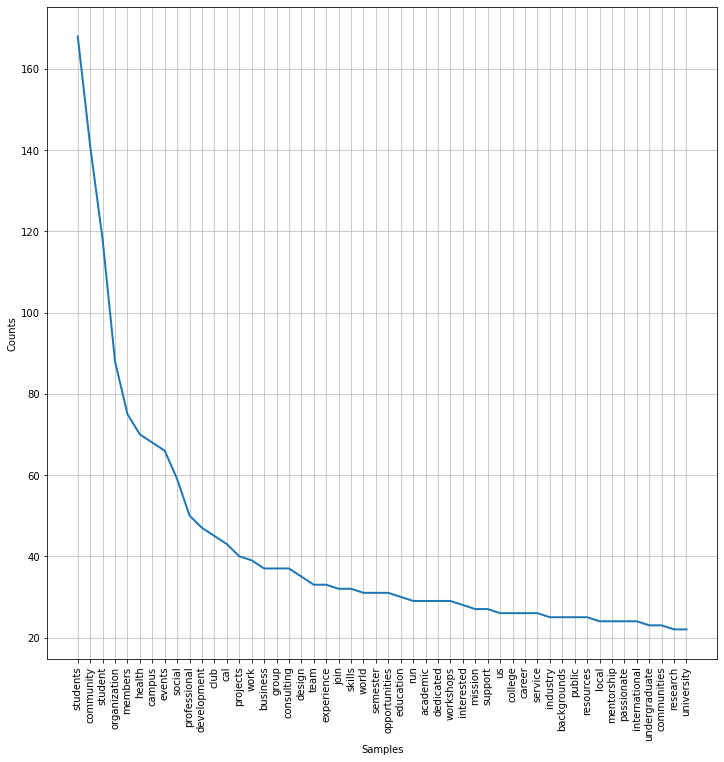

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [31]:
nltk.FreqDist(total_BOW).plot(50, cumulative=False)

In [32]:
vector_table, w2v_model = vectorize_table(cleaned_table, yield_model=True)
vector_table

Model Loss: 10894.7568359375


/home/tejashah88/extra-software/anaconda3/envs/sc-notebook/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/tejashah88/extra-software/anaconda3/envs/sc-notebook/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


,name,tags,clean_description,vector_sum
0,The Berkeley Alt. Protein Project,"[10, 11, 18]","[alt, protein, project, strives, build, health...","[-0.0047792876, -0.018060055, -0.0015440767, -..."
1,EthiCAL Apparel,"[2, 10, 20]","[ethical, apparel, student, run, social, enter...","[-0.001517847, -0.028812736, -0.00469081, -0.0..."
2,UC Rally Committee,"[20, 21]","[rally, committee, members, official, guardian...","[-0.00799562, -0.06756543, -0.007016178, 0.016..."
3,Formula Electric at Berkeley,"[2, 8, 9]","[join, us, building, cal, first, ever, formula...","[-0.011304441, -0.0073028617, -0.008322507, 0...."
4,Codebase,"[5, 6, 22]","[codebase, community, developers, empowers, st...","[0.016615184, -0.046349827, -3.264236e-05, -0...."
...,...,...,...,...
223,Berkeley Chinese Students And Scholars Associa...,"[7, 13, 19]","[chinese, students, scholars, association, bcs...","[-0.014315963, -0.06754638, -0.004327558, -0.0..."
224,Chinese People Union,"[7, 15, 19]","[chinese, people, union]","[1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-..."
225,Achievement in Mentorship (AIM),"[0, 4, 20]","[achievement, mentorship, aim, cal, nonprofit,...","[-0.015014298, -0.043793805, -0.003863216, -0...."
226,Codeology,"[5, 8, 22]","[codeology, student, run, club, fosters, self,...","[-0.00029108557, -0.03881571, -0.0062396275, -..."


/home/tejashah88/extra-software/anaconda3/envs/sc-notebook/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


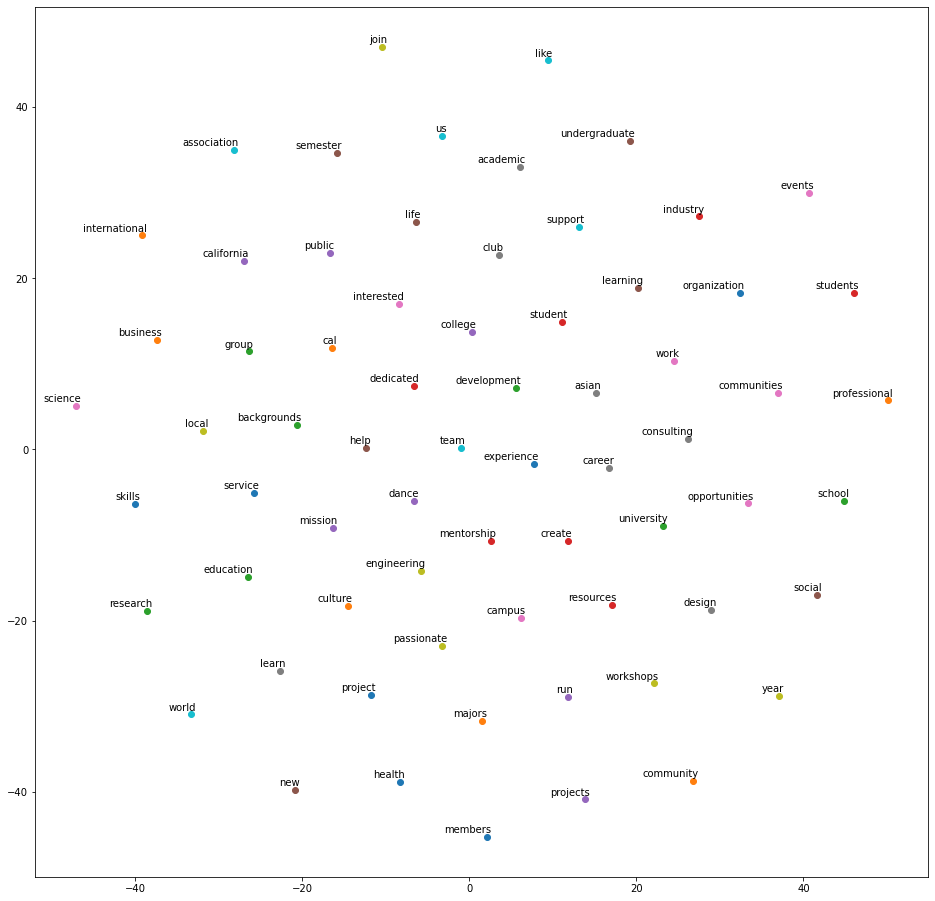

In [17]:
# Source: https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne

def tsne_plot(model):
    "Creates a TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
        
    tsne_model = TSNE(perplexity=60, n_components=2, init='pca', n_iter=1000, random_state=42)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    
tsne_plot(w2v_model)

In [33]:
distance_table = create_distance_table(vector_table)
distance_table

,The Berkeley Alt. Protein Project,EthiCAL Apparel,UC Rally Committee,Formula Electric at Berkeley,Codebase,Berkeley Phi Beta Lambda,Cal Seismic Design Team,SENDforC at UC Berkeley,BEAM- Berkeley Engineers and Mentors,Berkeley Finance Club,...,A Better Way at Berkeley,Creative Arts to Reinspire and Empower (C.A.R.E.),ONETrack International at UC Berkeley,Beta Alpha Psi,sproul.club,Berkeley Chinese Students And Scholars Association,Chinese People Union,Achievement in Mentorship (AIM),Codeology,Blue & Gold Yearbook
name,,,,,,,,,,,,,,,,,,,,,
The Berkeley Alt. Protein Project,1.000000,0.499606,0.511599,0.427625,0.653376,0.581426,0.650166,0.668972,-0.250578,0.641944,...,0.375598,0.050069,0.381866,0.570134,0.247627,0.525248,-0.250578,0.494298,0.610210,-0.250578
EthiCAL Apparel,0.499606,1.000000,0.642978,0.440194,0.624078,0.723089,0.714124,0.712083,-0.230672,0.560186,...,0.627475,0.306089,0.596195,0.599227,0.555672,0.754622,-0.230672,0.696275,0.758948,-0.230672
UC Rally Committee,0.511599,0.642978,1.000000,0.402989,0.628904,0.728816,0.645435,0.584804,-0.217551,0.609903,...,0.594780,0.228873,0.440070,0.634493,0.508112,0.861003,-0.217551,0.701904,0.762572,-0.217551
Formula Electric at Berkeley,0.427625,0.440194,0.402989,1.000000,0.485378,0.672327,0.499601,0.463608,-0.174250,0.391149,...,0.390165,0.123351,0.262080,0.684230,0.286565,0.436668,-0.174250,0.489626,0.630584,-0.174250
Codebase,0.653376,0.624078,0.628904,0.485378,1.000000,0.725300,0.804688,0.720825,-0.261657,0.621849,...,0.543144,0.174612,0.502635,0.584009,0.474605,0.740139,-0.261657,0.709368,0.800142,-0.261657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Berkeley Chinese Students And Scholars Association,0.525248,0.754622,0.861003,0.436668,0.740139,0.840719,0.677252,0.734200,-0.252725,0.653269,...,0.710141,0.340706,0.537454,0.709319,0.724761,1.000000,-0.252725,0.872308,0.838455,-0.252725
Chinese People Union,-0.250578,-0.230672,-0.217551,-0.174250,-0.261657,-0.185926,-0.283589,-0.260163,1.000000,-0.125881,...,-0.228962,-0.140765,-0.183370,-0.179836,-0.206764,-0.252725,1.000000,-0.196218,-0.157221,1.000000
Achievement in Mentorship (AIM),0.494298,0.696275,0.701904,0.489626,0.709368,0.772399,0.659552,0.779586,-0.196218,0.590666,...,0.754539,0.277798,0.559897,0.613789,0.726138,0.872308,-0.196218,1.000000,0.836232,-0.196218


<AxesSubplot:ylabel='name'>

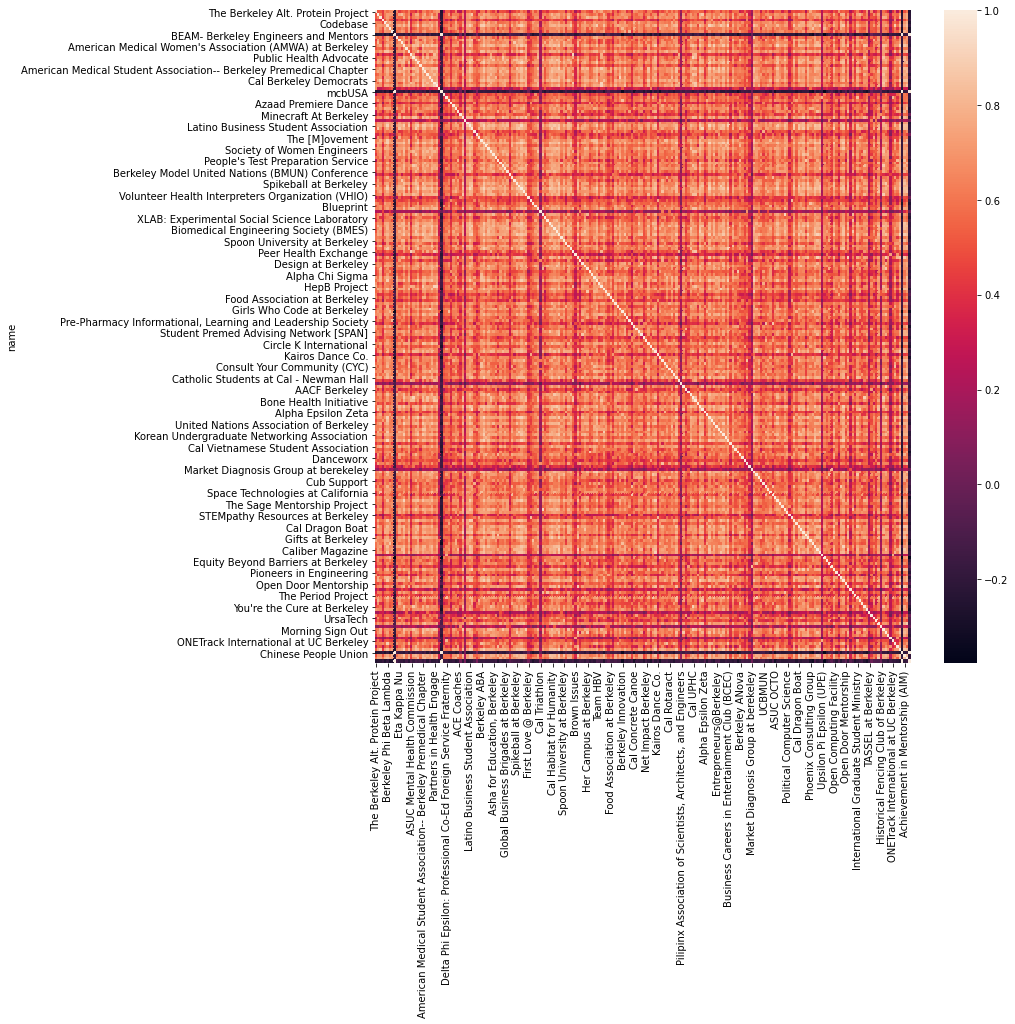

In [34]:
sns.heatmap(distance_table)

/home/tejashah88/extra-software/anaconda3/envs/sc-notebook/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

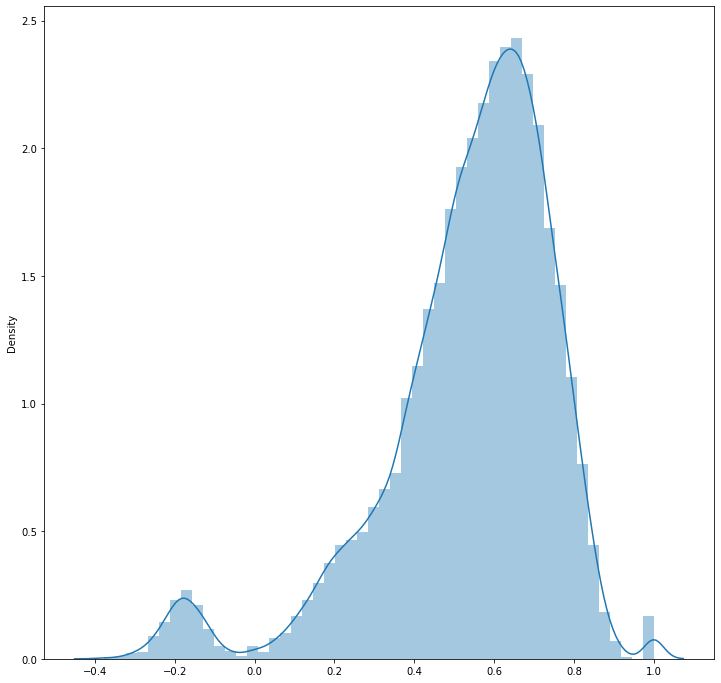

In [35]:
sns.distplot(distance_table)

In [38]:
recommendations = recommend(distance_table, club_db_df, 'sproul.club', 3)
recommendations

['Formula Electric at Berkeley', 'Entrepreneurs@Berkeley', 'MDB']

In [57]:
def get_description(club_name):
    return club_db_df[club_db_df['name'] == club_name]['description'].iloc[0]

In [58]:
get_description('Extended Reality at Berkeley')

'Extended Reality @ Berkeley is a registered student organization at Cal for people interested in experiencing or developing virtual and augmented reality technology and applications.'

In [132]:
def recommend_by_club(club_index = -1):
    if club_index == -1:
        club_index = random.randint(0, len(club_db_df))
    print("Club index: {}".format(club_index))
    club_name = club_db_df.iloc[club_index]['name']
    recommended = recommend(distance_table, club_db_df, club_name, 3)
    return club_name, recommended

In [162]:
recommend_by_club(46)

Club index: 46


('Hispanic Engineers and Scientists',
 ['STAR (Space Technologies And Rocketry)',
  'Phi Sigma Rho',
  'SENDforC at UC Berkeley'])

In [163]:
recommend_by_club()

Club index: 48


('Society of Women Engineers',
 ['STAR (Space Technologies And Rocketry)',
  'Cal Aero',
  'Minecraft At Berkeley'])

## Visualizing/Evaluating Performance

In [59]:
normed_df = vector_table['vector_sum'].apply(lambda arr: arr / np.linalg.norm(arr))
normed_vector_table = np.array([arr for arr in normed_df.to_numpy()])

In [62]:
means = np.mean(normed_vector_table.T, axis=1)
stds = np.std(normed_vector_table.T, axis=1)

print('Mean:', means)
print('Standard Dev:', stds)

print('\n\n')

print('Lowest mean:', np.min(means))
print('Highest mean:', np.max(means))

print('Lowest Standard Dev:', np.min(stds))
print('Highest Standard Dev:', np.max(stds))

Mean: [-0.02058105 -0.20889911 -0.00042697 -0.02739513  0.08889073 -0.10212437
 -0.03034748  0.00540978  0.06398085 -0.0273248   0.02444659 -0.03675741
 -0.05982748  0.03447933  0.00595416 -0.06420706  0.09877394 -0.03708637
 -0.0373486  -0.09200584 -0.04895785  0.00981725  0.01881082 -0.07659129
  0.0146188   0.04548638 -0.06500764  0.03395882  0.05003449  0.01946384
 -0.14411908  0.00882011 -0.00521228 -0.01832544 -0.08825047  0.09208547
  0.09382223 -0.10949335 -0.05705543  0.06044152  0.08679677 -0.08315612
  0.00962048 -0.04672593  0.16330113 -0.10225919 -0.08839873  0.05907857
 -0.08503365 -0.01897944 -0.06096673 -0.11836913  0.04125773  0.14847937
 -0.06909812 -0.11144564  0.01344824  0.07194169  0.00527732 -0.03288397
 -0.0359333  -0.00530262  0.02540125 -0.07354481 -0.04439562  0.00520709
  0.09771651  0.03769669 -0.0819593   0.06035589  0.03074212  0.10447687
 -0.05901427 -0.05437487  0.12024003 -0.13288178 -0.00445276  0.03386117
 -0.08459568  0.03190758  0.01866562 -0.03545

/home/tejashah88/extra-software/anaconda3/envs/sc-notebook/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/tejashah88/extra-software/anaconda3/envs/sc-notebook/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/tejashah88/extra-software/anaconda3/envs/sc-notebook/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future v

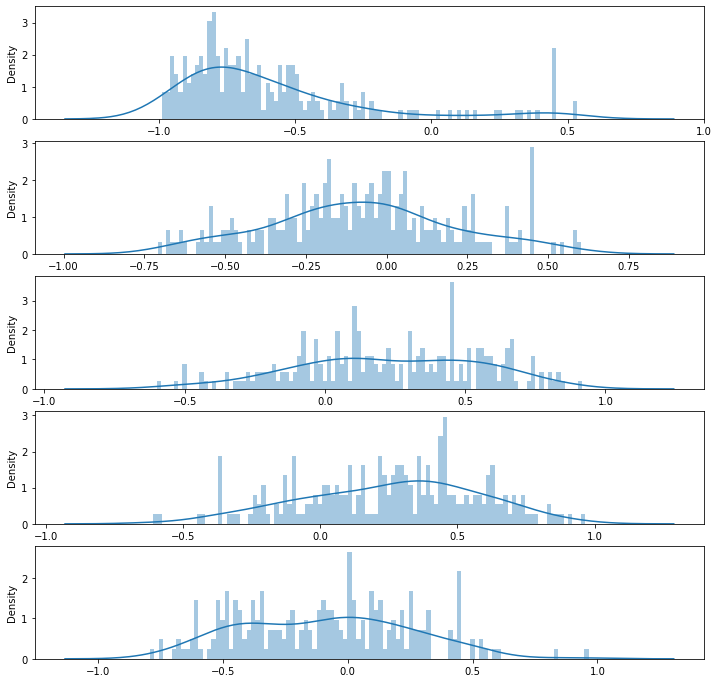

In [188]:
dims = normed_vector_table.shape[1]

fig, axs = plt.subplots(nrows=dims)

for i in range(dims):
    sns.distplot(normed_vector_table.T[i], bins=100, ax=axs[i])

## Student Profile Recommendation

In [44]:
# DEFUNCT
# DEFUNCT
# DEFUNCT

def favorite_recommendation(favorite_list, k):
    """
    Description:
    Returns k amount of recommendations based off of favorite_list specific to user.

    Input:
    favorite_list - array that contains names of clubs favorited
    k - integer amount of recommendations

    Output:
    recommendations - array of club names recommended

    """
    vector_1 = np.mean(vector_table[vector_table['name'].isin(favorite_list)]['vector_sum'])
    distances = []
    
    for vector_2 in vector_table['vector_sum']:
        cosine_sim = 1 - spatial.distance.cosine(vector_1, vector_2)
        distances += [cosine_sim]
    
    profile_distance = club_db_df.assign(distances = distances) 
    filtered_profile_distance = profile_distance[~profile_distance['name'].isin(favorite_list)]
    sorted_profile_distances = filtered_profile_distance.sort_values(by = 'distances', ascending = True)
    recommendations = list(sorted_profile_distances['name'].iloc[0: k])
    return recommendations
        

Edit favorite_list to see what it will recommend

In [45]:
favorite_list1 = [
    'PlexTech', 
    'Codebase', 
    'Fintech at Berkeley', 
    'Pilipinx Association of Scientists, Architects, and Engineers'
    ]

favorite_recommendation(favorite_list1, 6)

['Blue & Gold Yearbook',
 'Chinese People Union',
 'mcbUSA',
 'BEAM- Berkeley Engineers and Mentors',
 'Market Diagnosis Group at berekeley',
 'TASSEL at Berkeley']

In [103]:
favorite_list2 = [
    'Berkeley Legends', 
    'Cal Animage Alpha'
    ]

favorite_recommendation(favorite_list2, 6)

['Bioengineering Honor Society',
 'Home of Students Christian Fellowship',
 'Historical Fencing Club of Berkeley',
 'Cal Aero',
 'Art & Mind',
 'Pilipinx Association of Scientists, Architects, and Engineers']

In [47]:
favorite_list2 = [
    'Berkeley Legends', 
    'Cal Animage Alpha'
    ]


favorite_recommendation(favorite_list2, 6)

['Blue & Gold Yearbook',
 'Chinese People Union',
 'mcbUSA',
 'BEAM- Berkeley Engineers and Mentors',
 'Cal Triathlon',
 'Market Diagnosis Group at berekeley']

In [48]:
favorite_list3 = [
    'Consult Your Community (CYC)',
    'Venture Strategy Solutions',
    'Abba Modern',
    'TASSEL at Berkeley',
    'Klesis Christian Fellowship',
    'Entrepreneurs@Berkeley'
                ]


favorite_recommendation(favorite_list3, 6)

['Blue & Gold Yearbook',
 'BEAM- Berkeley Engineers and Mentors',
 'Chinese People Union',
 'mcbUSA',
 'Cal Triathlon',
 'Creative Arts to Reinspire and Empower (C.A.R.E.)']

In [51]:
# DEFUNCT
# DEFUNCT
# DEFUNCT

def favorite_recommendation2(favorite_list, k):
    """
    Description:
    Returns k amount of recommendations based off of favorite_list specific to user.

    Input:
    favorite_list - array that contains names of clubs favorited
    k - integer amount of recommendations

    Output:
    recommendations - array of club names recommended

    """
    club_list_pool = []
    for club in favorite_list:
        club_list = recommend(distance_table, club_db_df, club, 6)
        for recommended_club in club_list:
            club_list_pool += [recommended_club]
            
            
    not_in_favorite = [club for club in club_list_pool if club not in favorite_list]
    
    unique_recommended = list(dict.fromkeys(not_in_favorite))
    
    sample_len = len(unique_recommended)
    recommended_indices = random.sample(range(1, sample_len), k)
    recommended = [not_in_favorite[recommended_index] for recommended_index in recommended_indices]
    
    print(recommended)
    print(len(recommended))
    final_recommendation = recommended[:k]
    
    return final_recommendation
        

In [102]:
favorite_recommendation2(['Computer Science Mentors (CSM)', 'Minecraft At Berkeley', 'Cal Hacks'], 6)

['MDB', 'Girls Teaching Girls to Code @ Berkeley', 'GroTech @ Berkeley', 'iGEM at Berkeley', 'ASUC OCTO', 'Girls Who Code at Berkeley']
6


['MDB',
 'Girls Teaching Girls to Code @ Berkeley',
 'GroTech @ Berkeley',
 'iGEM at Berkeley',
 'ASUC OCTO',
 'Girls Who Code at Berkeley']

In [53]:
favorite_recommendation2(['Computer Science Mentors (CSM)', 'Minecraft At Berkeley', 'Cal Hacks'], 6)


['FemTech', 'UrsaTech', 'Fintech at Berkeley', 'ASUC OCTO', 'Cal RoboBears', 'Blockeley']
6


['FemTech',
 'UrsaTech',
 'Fintech at Berkeley',
 'ASUC OCTO',
 'Cal RoboBears',
 'Blockeley']

In [55]:
def favorite_recommendation3(favorite_list, interest_list, k):
    """
    Description:
    Returns k amount of recommendations based off of favorite_list and interest_list specific to user.

    Input:
    favorite_list - array that contains names of clubs favorited
    interest_list - array that contains tags (aka interests) student has chosen
    k - integer amount of recommendations

    Output:
    recommendations - array of club names recommended

    """
    #condition that favorite list doesn't exist -- use interest list
    if len(favorite_list) ==0:
        new_club_df = club_db_df[['name', 'tags']]
        intersections = [set.intersection(set(interest_list), set(i)) for i in new_club_df['tags']]
        new_club_df['intersection_with_interests'] = [list(i) for i in intersections]
        new_club_df['num_intersection'] = [len(i) for i in new_club_df['intersection_with_interests']]
        new_club_df = new_club_df.sort_values('num_intersection', ascending = False)
        final_recommendation = list(new_club_df['name'][:k])
    #everything below this point is favorite_recommendation2 above    
    else:
        club_list_pool = []
        for club in favorite_list:
            club_list = recommend(distance_table, club_db_df, club, 6)
            for recommended_club in club_list:
                club_list_pool += [recommended_club]
    
        not_in_favorite = [club for club in club_list_pool if club not in favorite_list]

        unique_recommended = list(dict.fromkeys(not_in_favorite))
        sample_len = len(unique_recommended)
        recommended_indices = random.sample(range(1, sample_len), k)
        recommended = [not_in_favorite[recommended_index] for recommended_index in recommended_indices]

        #print(recommended)
        #print(len(recommended))
        final_recommendation = recommended[:k]

    return final_recommendation
        
    
favorite_recommendation3([], [2,4,6], 5)

['Voyager Consulting',
 'Consult Your Community (CYC)',
 'Pinnacle Consulting',
 'Venture Strategy Solutions',
 'Berkeley ABA']